# Binding site detection


In [64]:
# Import libraries
from pathlib import Path
import time
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import nglview as nv
import openbabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport

from opencadd.structure.core import Structure

In [65]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/Breast_cancer_brain_metastasis/wang_Gene/AIDD/14_Binding_site_detection/data


In [99]:
pdb_id = "4J8M"

In [104]:
import MDAnalysis as mda
from MDAnalysis.core.universe import Universe
from io import StringIO
import requests
from collections import OrderedDict

# 定义函数来下载 PDB 结构
def download_pdb_structure(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        response = requests.get(url, verify=False)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Failed to download {pdb_id}. Status code: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while downloading {pdb_id}: {e}")
        return None

# 定义结构和配体信息


# 下载结构文件
structures = {pdb_id: download_pdb_structure(pdb_id)}

# 保存到data目录下
with open(f"{DATA}/{pdb_id}.pdb", "w") as f:
    f.write(structures[pdb_id])





显示基于 PDB ID 的复合物

In [107]:
ngl_viewer = nv.show_pdbid(pdb_id)
# add the ligands
ngl_viewer.add_representation(repr_type="ball+stick", selection="hetero and not water")
# center view on binding site
ngl_viewer.center("ligand")
ngl_viewer

URLError: <urlopen error EOF occurred in violation of protocol (_ssl.c:1131)>

In [108]:
# render a static image
ngl_viewer.render_image(trim=True, factor=2);

In [109]:
ngl_viewer._display_image()

## 使用 PLIP 分析蛋白质-配体相互作用
PLIP 提供用于自动分析的 web 服务器，但遗憾的是没有 API。我们可以尝试使用 HTML 表单，就像我们使用标准 web UI 一样，但由于该库本身是 Python-3 兼容的，并且非常容易通过 pip 安装，我们只需在本地使用即可，以简化操作。

PLIP 以 PDB 文件作为输入，因此我们可以将 PDB 文件传递给 PLIP，让它施展魔法。 BindingSiteReport 类处理 PDBComplex 中检测到的每个结合位点，并创建一个包含我们感兴趣的（八个）字段的对象，即

- hydrophobic interaction : `hydrophobic`
- hydrogen bond : `hbond`
- water bridge : `waterbridge`
- salt bridge : `saltbridge`
- π-stacking (parallel and perpendicular) : `pistacking`
- π- cation : `pication`
- halogen bond : `halogen`
- metal complexation : `metal`

这些字段分为 `<field>_features` （包含列名）和 `<field>_info` （包含实际记录）。如果我们遍历对象，使用 `getattr()` 检索正确的属性名，我们可以组成一个字典，可以传递给 `pandas.DataFrame` 以获得良好的概览。

此词典由两个级别组成：

- 一级是检测到的结合位点。
- 对于每个结合位点，我们有一个包含八个列表的子词典，每个列表对应一种特定的相互作用。
  - 每个列表将包含第一行的列名，以及以下的数据（如有）。

In [110]:
def retrieve_plip_interactions(pdb_file):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(pdb_file)  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    # loop over binding sites
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas DataFrame
        keys = (
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RESNR', 'RESTYPE', ..., 'LIGCOO', 'PROTCOO')
        # 2. information for each of these features, e.g. for hydrophobic
        # (residue nb, residue type,..., ligand atom 3D coord., protein atom 3D coord.)
        interactions = {
            k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
            for k in keys
        }
        sites[key] = interactions
    return sites

In [111]:
interactions_by_site = retrieve_plip_interactions(f"{DATA}/{pdb_id}.pdb")

让我们看看检测到多少个结合位点：

In [112]:
print(
    f"Number of binding sites detected in {pdb_id} : "
    f"{len(interactions_by_site)}\n"
    f"with {interactions_by_site.keys()}"
)

Number of binding sites detected in 4J8M : 6
with dict_keys(['CJ5:A:501', 'DMS:A:504', 'DMS:A:505', 'EDO:A:506', 'MG:A:502', 'PO4:A:503'])



# 可以 根据这个 https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index 来获取打分的标准。

In [114]:
index_of_selected_site = 0
selected_site = list(interactions_by_site.keys())[index_of_selected_site]
print(selected_site)

CJ5:A:501


### 交互类型表 ¶

我们可以为结合位点和特定的相互作用类型构建一个 `pandas.DataFrame` 。

In [115]:
def create_df_from_binding_site(selected_site_interactions, interaction_type="hbond"):
    """
    Creates a data frame from a binding site and interaction type.

    Parameters
    ----------
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    interaction_type : str
        The interaction type of interest (default set to hydrogen bond).

    Returns
    -------
    pd.DataFrame :
        DataFrame with information retrieved from PLIP.
    """

    # check if interaction type is valid:
    valid_types = [
        "hydrophobic",
        "hbond",
        "waterbridge",
        "saltbridge",
        "pistacking",
        "pication",
        "halogen",
        "metal",
    ]

    if interaction_type not in valid_types:
        print("!!! Wrong interaction type specified. Hbond is chosen by default!!!\n")
        interaction_type = "hbond"

    df = pd.DataFrame.from_records(
        # data is stored AFTER the column names
        selected_site_interactions[interaction_type][1:],
        # column names are always the first element
        columns=selected_site_interactions[interaction_type][0],
    )
    return df

**疏水相互作用**

在下个细胞中，我们展示了从所选结合位点处的疏水相互作用。

In [116]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hydrophobic")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,139,LEU,A,501,CJ5,A,4.00,4401,246,"(119.353, 103.582, 158.192)","(122.829, 105.517, 157.793)"
1,147,VAL,A,501,CJ5,A,3.44,4397,366,"(117.242, 106.2, 152.03)","(119.99, 107.509, 153.631)"
2,164,LEU,A,501,CJ5,A,3.83,4391,669,"(116.106, 106.865, 150.003)","(117.318, 110.024, 148.213)"
3,210,LEU,A,501,CJ5,A,3.86,4418,1461,"(117.315, 108.584, 156.639)","(116.745, 112.396, 156.442)"
4,212,TYR,A,501,CJ5,A,3.99,4409,1497,"(120.915, 104.527, 163.671)","(122.802, 108.045, 163.654)"
5,217,THR,A,501,CJ5,A,3.90,4403,1566,"(117.334, 103.384, 159.483)","(115.53, 101.451, 162.354)"
6,281,ALA,A,501,CJ5,A,3.91,4389,2607,"(114.85, 106.622, 152.072)","(113.702, 103.178, 153.515)"
7,147,VAL,A,501,CJ5,A,3.44,4417,365,"(118.313, 108.779, 157.755)","(120.985, 108.623, 155.59)"
8,194,LEU,A,501,CJ5,A,3.62,4420,1179,"(116.178, 108.305, 158.762)","(114.865, 111.02, 160.76)"
9,279,VAL,A,501,CJ5,A,3.69,4390,2575,"(114.886, 106.918, 150.7)","(113.42, 106.766, 147.316)"


In [117]:
# 保存疏水相互作用数据
df_hbond = create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hbond")
df_hbond.to_csv(f"{DATA}/hbond.csv", index=False)

**氢相互作用**

如果对氢相互作用感兴趣，表格可以按以下方式生成

In [119]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hbond")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,213,ALA,A,501,CJ5,A,False,2.05,2.90,172.79,True,1510,Nam,4413,N2,"(118.921, 108.676, 162.352)","(119.064, 109.798, 165.026)"
1,211,GLU,A,501,CJ5,A,False,2.06,2.89,151.22,False,4414,Npl,1477,O2,"(118.32, 109.306, 161.302)","(118.087, 112.084, 162.047)"
2,213,ALA,A,501,CJ5,A,False,1.93,2.81,159.70,False,4411,Npl,1513,O2,"(119.849, 106.556, 162.929)","(119.782, 106.969, 165.705)"
3,274,ASP,A,501,CJ5,A,True,1.85,2.74,170.39,False,4387,Nam,2502,O2,"(115.947, 105.943, 154.146)","(113.552, 106.798, 155.176)"
4,274,ASP,A,501,CJ5,A,True,1.92,2.73,149.86,False,4398,Nam,2503,O3,"(116.511, 105.056, 156.321)","(113.808, 105.227, 156.691)"


In [120]:
# 保存氢相互作用数据
df_hbond = create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hbond")
df_hbond.to_csv(f"{DATA}/hbond.csv", index=False)

**水桥相互作用**



In [121]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="waterbridge")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,217,THR,A,501,CJ5,A,3.39,2.93,159.41,71.28,True,1560,Nam,4407,N2,4565,"(120.68, 102.555, 162.395)","(116.673, 101.422, 165.074)","(118.861, 100.02, 163.719)"


In [122]:
# 保存水桥相互作用数据
df_waterbridge = create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="waterbridge")
df_waterbridge.to_csv(f"{DATA}/waterbridge.csv", index=False)

**盐桥相互作用**


In [123]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="saltbridge")

,RESNR,RESTYPE,RESCHAIN,PROT_IDX_LIST,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,PROTISPOS,LIG_GROUP,LIG_IDX_LIST,LIGCOO,PROTCOO


In [125]:
# 保存盐桥相互作用数据
df_saltbridge = create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="saltbridge")
df_saltbridge.to_csv(f"{DATA}/saltbridge.csv", index=False)

**卤素相互作用**

让我们也看看卤素相互作用：

In [126]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="halogen")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST,DON_ANGLE,ACC_ANGLE,DON_IDX,DONORTYPE,ACC_IDX,ACCEPTORTYPE,LIGCOO,PROTCOO


In [127]:
# 保存卤素相互作用数据
df_halogen = create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="halogen")
df_halogen.to_csv(f"{DATA}/halogen.csv", index=False)

### 可视化使用 NGLView ¶

现在，让我们尝试在 NGL 查看器中展示这些相互作用。我们可以在相互作用点之间（ `LIGCOO` 和 `PROTCOO` 在 `pandas.DataFrame` 中）绘制圆柱体，并按照 `color_map` 中所示的颜色编码

In [128]:
color_map = {
    "hydrophobic": [0.90, 0.10, 0.29],
    "hbond": [0.26, 0.83, 0.96],
    "waterbridge": [1.00, 0.88, 0.10],
    "saltbridge": [0.67, 1.00, 0.76],
    "pistacking": [0.75, 0.94, 0.27],
    "pication": [0.27, 0.60, 0.56],
    "halogen": [0.94, 0.20, 0.90],
    "metal": [0.90, 0.75, 1.00],
}

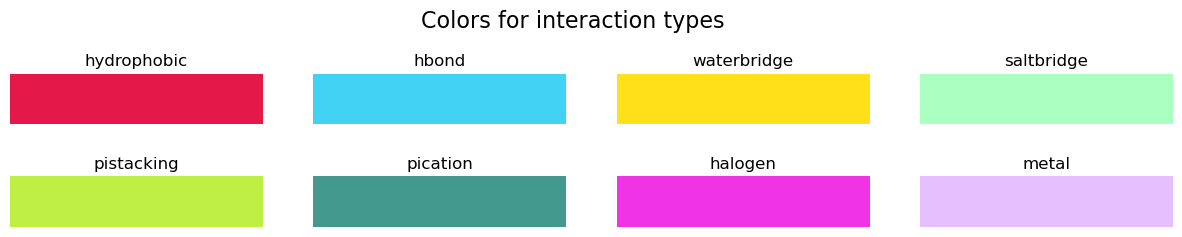

In [129]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 2))
plt.subplots_adjust(hspace=1)
fig.suptitle("Colors for interaction types", size=16, y=1.2)

for ax, (interaction, color) in zip(fig.axes, color_map.items()):
    ax.imshow(np.zeros((1, 5)), cmap=colors.ListedColormap(color_map[interaction]))
    ax.set_title(interaction, loc="center")
    ax.set_axis_off()
plt.show()

定义一个辅助函数以显示交互。

In [130]:
def show_interactions_3d(
    pdb_id, selected_site_interactions, highlight_interaction_colors=color_map
):
    """
    3D visualization of protein-ligand interactions.

    Parameters
    ----------
    pdb_id : str
        The pdb ID of interest.
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    highlight_interaction_colors : dict
        The colors used to highlight the different interaction types.

    Returns
    -------
    NGL viewer with explicit interactions given by PLIP.
    """

    # Create NGLviewer
    viewer = nv.NGLWidget(height="600px", default=True, gui=True)
    # Add protein
    prot_component = viewer.add_pdbid(pdb_id)
    # Add the ligands
    viewer.add_representation(repr_type="ball+stick", selection="hetero and not water")

    interacting_residues = []
    for interaction_type, interaction_list in selected_site_interactions.items():
        color = highlight_interaction_colors[interaction_type]
        if len(interaction_list) == 1:
            continue
        df_interactions = pd.DataFrame.from_records(
            interaction_list[1:], columns=interaction_list[0]
        )
        for _, interaction in df_interactions.iterrows():
            name = interaction_type
            # add cylinder between ligand and protein coordinate
            viewer.shape.add_cylinder(
                interaction["LIGCOO"],
                interaction["PROTCOO"],
                color,
                [0.1],
                name,
            )
            interacting_residues.append(interaction["RESNR"])
    # Display interacting residues
    res_sele = " or ".join([f"({r} and not _H)" for r in interacting_residues])
    res_sele_nc = " or ".join([f"({r} and ((_O) or (_N) or (_S)))" for r in interacting_residues])
    prot_component.add_ball_and_stick(sele=res_sele, colorScheme="chainindex", aspectRatio=1.5)
    prot_component.add_ball_and_stick(sele=res_sele_nc, colorScheme="element", aspectRatio=1.5)
    # Center on ligand
    viewer.center("ligand")
    return viewer

In [131]:
viewer_3d = show_interactions_3d(pdb_id, interactions_by_site[selected_site])
viewer_3d

NGLWidget()

In [132]:
viewer_3d.render_image(trim=True, factor=2, transparent=True);

In [133]:
viewer_3d._display_image()